# Causal Inferense

Propensity Score Matching — это метод установления причинно-следственных связей. Он стремится сбалансировать группы воздействия по различным факторам, чтобы сделать их сопоставимыми, что позволяет сделать выводы о причинном влиянии воздействия на целевую переменную с использованием наблюдаемых данных.

Это особенно важно, когда проведение AB-тестирования невозможно. В этом ноутбуке мы изучим основы метода PSM.

Экспериментальные данные vs. Наблюдаемые данные

В этом разделе мы кратко рассмотрим два типа данных, которые имеют значение при анализе причинно-следственных связей. Давайте определимся с тремя ключевыми терминами:

**Целевая переменная**: переменная, представляющая интерес, для которой мы хотим понять влияние воздействия.  
**Переменная воздействия** (Treatment): переменная, влияние которой на целевую переменную мы хотим оценить.  
**Связывающая переменная**: Переменная, которая влияет как на воздействие, так и на целевую переменную. В некоторых контекстах её также называют ковариатой.

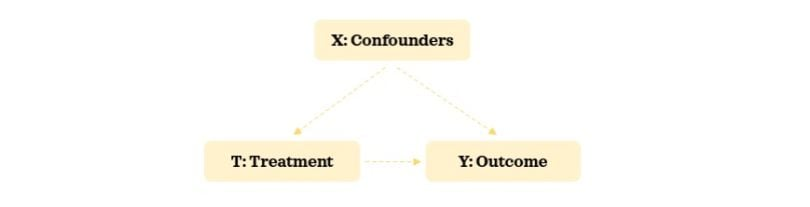

Экспериментальные данные — это данные, собранные в рамках AB-теста. Данные случайным образом разбиваются на контрольные и тестовые, что гарантирует отсутствие смещения в группах. К примеру, мы давали разное мороженое разным людям, чтобы оценить, какая группа людей будет более довольной.

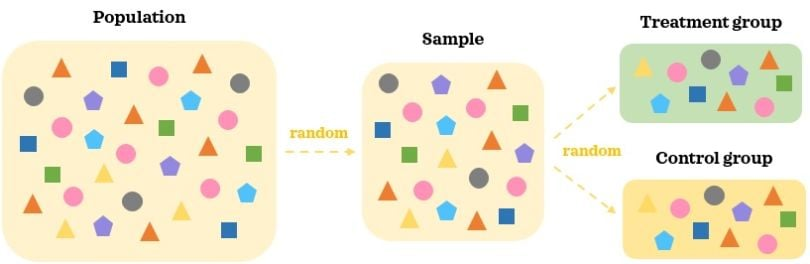

Однако чаще данные являются не экспериментальными, а наблюдаемыми - когда влияние эффекта было назначено не нами, а кем-то другим (скажем, люди сами выбирали тот или другой вид мороженого).

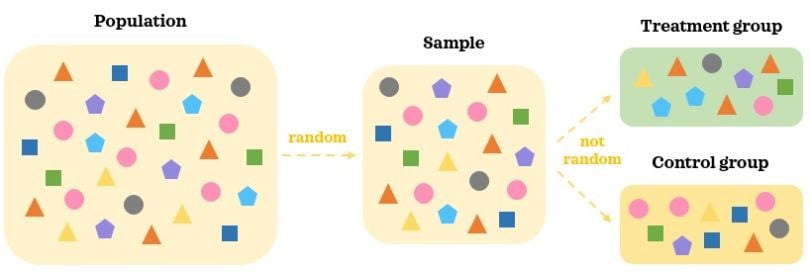

PSM позволяет сбалансировать данные выборки, чтобы они получились более однородными.

# ***Шаг 1: Сбор данных***
Это самый важный шаг в анализе причинно-следственных связей. Цель этого шага — собрать информацию обо всех возможных связывающих переменных на основе экспертных знаний в соответствующей области. Если важные смешивающие переменные были упущены, существует риск неверного вывода о причинном влиянии воздействия на исход.

При работе с временными рядами, временные смешивающие факторы должны отражать свое состояние до воздействия, а временной исход должен быть зафиксирован после воздействия. Например, доход от продаж в онлайн-шопинге является временной переменной. Если мы решим использовать его в качестве смешивающего фактора, он должен фиксировать данные о доходе до того, как произошло воздействие.

В качестве нашего примера мы будем использовать широко доступные данные о пассажирах Титаника. Для простоты сведем количество смешивающих переменных к минимуму.

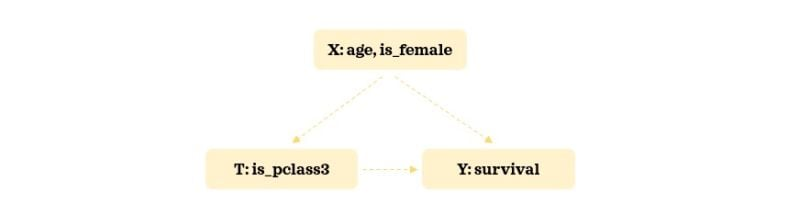

Давайте попробуем оценить то, насколько нахождение в третьем классе влияло на выживаемость пассажиров. Поставим нужные библиотеки и загрузим данные.

In [ ]:
!pip install causalinference

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:.2f}".format
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid', context='talk')
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, f1_score
from causalinference import CausalModel
df = sns.load_dataset('titanic')
df['is_pclass3'] = df['pclass']==3
df['is_female'] = df['sex']=='female'
df = df.filter(['survived', 'is_pclass3', 'is_female', 'age'])\
       .dropna().reset_index(drop=True)
df

,survived,is_pclass3,is_female,age
0,0,True,False,22.00
1,1,False,True,38.00
2,1,True,True,26.00
3,1,False,True,35.00
4,0,True,False,35.00
...,...,...,...,...
709,0,True,True,39.00
710,0,False,False,27.00
711,1,False,True,19.00
712,1,False,False,26.00


In [ ]:
TREATMENT = 'is_pclass3'
OUTCOME = 'survived'
df.groupby(TREATMENT)[OUTCOME].describe()

,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,0.57,0.50,0.00,0.00,1.00,1.00,1.00
True,355.00,0.24,0.43,0.00,0.00,0.00,0.00,1.00


Как мы видим, вероятность выживания пассажира третьего класса составила 24 процента, а из других классов (контрольная группа) 57 процентов. Давайте оценим распределение связывающих переменных.

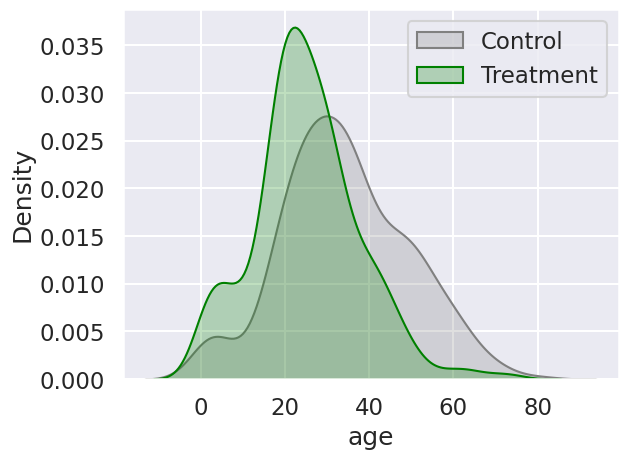

In [ ]:
C_COLOUR = 'grey'
T_COLOUR = 'green'
C_LABEL = 'Control'
T_LABEL = 'Treatment'
sns.kdeplot(data=df[~df[TREATMENT]], x='age', fill=True,
            color=C_COLOUR, label=C_LABEL)
sns.kdeplot(data=df[df[TREATMENT]], x='age', fill=True,
            color=T_COLOUR, label=T_LABEL)
plt.legend();

Видно, что в тестовой группе пассажиры более молодые, чем в контрольной. Оценим также распределение пола.

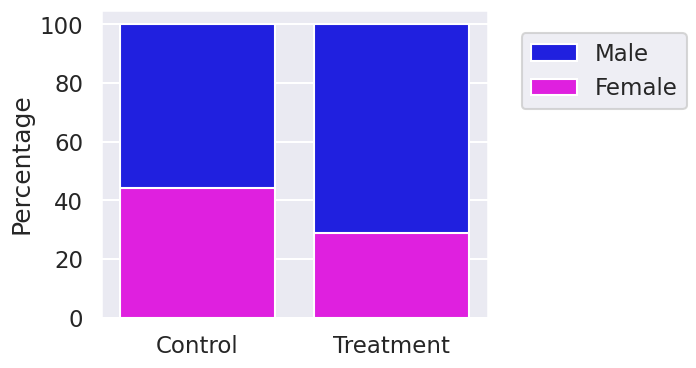

In [ ]:
F_COLOUR = 'magenta'
M_COLOUR = 'blue'
F_LABEL = 'Female'
M_LABEL = 'Male'
gender = 100 * pd.crosstab(df[TREATMENT].replace({True: T_LABEL,
                                                  False: C_LABEL}),
                           df['is_female'].replace({True: 'Female',
                                                    False: 'Male'}),
                           normalize='index')
gender['All'] = 100
plt.figure(figsize=(5, 4))
sns.barplot(data=gender, x=gender.index.astype(str),  y="All",
            color=M_COLOUR, label=M_LABEL)
sns.barplot(data=gender, x=gender.index.astype(str),  y='Female',
            color=F_COLOUR, label=F_LABEL)
plt.legend(loc='center', bbox_to_anchor=(1.3, 0.8))
plt.xlabel('')
plt.ylabel('Percentage');

Как мы видим, в тестовой группе оказалось больше мужчин, чем в контрольной. Из-за этого нельзя полагать, что разница в вероятности выживания обусловлена только нахождением в третьем классе. Давайте попробуем сделать данные группы сопоставимыми.

# Оценка Propensity Score

Давайте при помощи логистической регрессии оценим вероятность того, что объект попал в тестовую группу.

In [ ]:
# Build a descriptive model
t = df[TREATMENT]
X = pd.get_dummies(df.drop(columns=[OUTCOME, TREATMENT]))
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('logistic_classifier', LogisticRegression())
])
pipe.fit(X, t)
# Predict
threshold = 0.5
df['proba'] = pipe.predict_proba(X)[:,1]
df['logit'] = df['proba'].apply(lambda p: np.log(p/(1-p)))
df['pred'] = np.where(df['proba']>=threshold, 1, 0)
df.head()

,survived,is_pclass3,is_female,age,proba,logit,pred
0,0,True,False,22.00,0.67,0.70,1
1,1,False,True,38.00,0.26,-1.02,0
2,1,True,True,26.00,0.40,-0.40,0
3,1,False,True,35.00,0.30,-0.87,0
4,0,True,False,35.00,0.51,0.03,1


Мы не делим данные на тест и обучения, поскольку наша цель не получить предсказания для новых данных, а оценить вероятности для уже существующих. Оценим модель:

In [ ]:
print(f"Accuracy: {np.mean(df[TREATMENT]==df['pred']):.4f},\
 ROC AUC: {roc_auc_score(df[TREATMENT], df['proba']):.4f},\
 F1-score: {f1_score(df[TREATMENT], df['pred']):.4f}")
# Visualise confusion matrix
pd.crosstab(df[TREATMENT], df['pred']).rename(columns={0: False,
                                                       1:True})

Accuracy: 0.6695, ROC AUC: 0.7197, F1-score: 0.6776


pred,False,True
is_pclass3,,
False,230,129
True,107,248


Посмотрим на распределение PS и логитов:

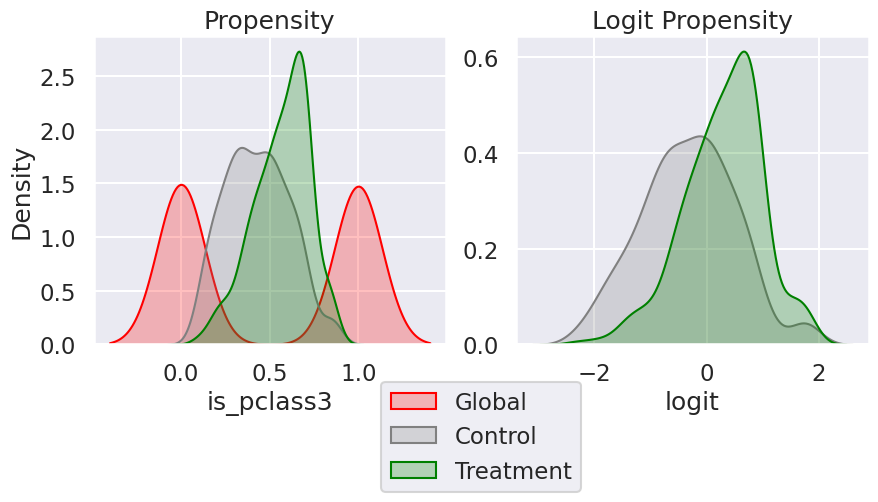

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
# Visualise propensity
sns.kdeplot(data=df, x=TREATMENT, fill=True,
            color='red', label='Global', ax=ax[0])
sns.kdeplot(data=df[~df[TREATMENT]], x='proba', fill=True,
            color=C_COLOUR, label=C_LABEL, ax=ax[0])
sns.kdeplot(data=df[df[TREATMENT]], x='proba', fill=True,
            color=T_COLOUR, label=T_LABEL, ax=ax[0])
ax[0].set_title('Propensity')
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
# Visualise logit propensity
sns.kdeplot(data=df[~df[TREATMENT]], x='logit', fill=True,
            color=C_COLOUR, label=C_LABEL, ax=ax[1])
sns.kdeplot(data=df[df[TREATMENT]], x='logit', fill=True,
            color=T_COLOUR, label=T_LABEL, ax=ax[1])
ax[1].set_title('Logit Propensity')
ax[1].set_ylabel("");

Как мы видим, в данных группах имеются определённые пересечения. Это хорошо! Значит есть из чего собирать данные :)



# Шаг 3: Сопоставление наблюдений
Теперь нам требуется сопоставить наиболее похожих контрольных пассажиров с пассажирами из тестовой группы. Найти похожих пассажиров по одной измеримой величине (PS) гораздо проще, чем делать это по множеству измерений (смешивающих факторов). По принципу это схоже с методами уменьшения размерности. Propensity score является балансирующим показателем, т.е. если мы сопоставим пассажиров на основе этой величины, распределение факторов между сопоставленными пассажирами, скорее всего, будет схожим.

Давайте попробуем сопоставить контрольных и тестовых пассажиров. При этом некоторые контрольные пользователи могут быть сопоставлены разным тестовым пассажирам, а какие-то контрольные пассажиры могут вовсе не найти себе пару.

In [ ]:
# Sort by 'logit' so it's quicker to find match
df.sort_values('logit', inplace=True)
n = len(df)-1
for i, (ind, row) in enumerate(df.iterrows()):
    # Match the most similar untreated record to each treated record
    if row[TREATMENT]:
        # Find the closest untreated match among records sorted
        # higher. 'equal_or_above would' be more accurate but
        # used 'above' for brevity
        if i<n:
            above = df.iloc[i:]
            control_above = above[~above[TREATMENT]]
            match_above = control_above.iloc[0]
            distance_above = match_above['logit'] - row['logit']
            df.loc[ind, 'match'] = match_above.name
            df.loc[ind, 'distance'] = distance_above

        # Find the closest untreated match among records sorted
        # lower. 'equal_or_below' would be more accurate but
        # used 'below' for brevity
        if i>0:
            below = df.iloc[:i-1]
            control_below = below[~below[TREATMENT]]
            match_below = control_below.iloc[-1]
            distance_below = match_below['logit'] - row['logit']
            if i==n:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below

            # Only overwrite if match_below is closer than match_above
            elif distance_below<distance_above:
                df.loc[ind, 'match'] = match_below.name
                df.loc[ind, 'distance'] = distance_below
df[df[TREATMENT]]

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
385,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
679,0,True,False,74.00,0.12,-2.01,0,156.00,-0.06
91,0,True,False,70.50,0.14,-1.82,0,74.00,-0.03
586,0,True,True,48.00,0.18,-1.55,0,25.00,-0.04
225,0,True,False,65.00,0.18,-1.54,0,601.00,-0.01
...,...,...,...,...,...,...,...,...,...
6,0,True,False,2.00,0.85,1.75,1,329.00,-0.05
132,0,True,False,1.00,0.86,1.80,1,329.00,-0.10
628,1,True,False,1.00,0.86,1.80,1,273.00,-0.05
309,0,True,False,1.00,0.86,1.80,1,273.00,-0.05


Сопоставление выполнено. Хочется отметить, что был использован один из наиболее простых подходов, но иногда стоит присмотреться к более сложным методам. Составим новый датафрейм

In [ ]:
indices = df[df['match'].notna()].index.\
          append(pd.Index(df.loc[df['match'].notna(), 'match']))
matched_df = df.loc[indices].reset_index(drop=True)
matched_df

,survived,is_pclass3,is_female,age,proba,logit,pred,match,distance
0,1,True,True,63.00,0.09,-2.33,0,221.00,0.00
1,0,True,False,74.00,0.12,-2.01,0,156.00,-0.06
2,0,True,False,70.50,0.14,-1.82,0,74.00,-0.03
3,0,True,True,48.00,0.18,-1.55,0,25.00,-0.04
4,0,True,False,65.00,0.18,-1.54,0,601.00,-0.01
...,...,...,...,...,...,...,...,...,...
705,1,False,False,3.00,0.84,1.69,1,NaN,NaN
706,1,False,False,3.00,0.84,1.69,1,NaN,NaN
707,1,False,False,2.00,0.85,1.75,1,NaN,NaN
708,1,False,False,2.00,0.85,1.75,1,NaN,NaN


Эти данные должны быть разбиты на тестовую и контрольную выборки более сбалансированным образом. Давайте оценим это.

# Оценка качества сопоставления

Давайте посмотрим что вышло при текущем разбиении

In [ ]:
COLUMNS = ['age', 'is_female', OUTCOME]
matches = pd.merge(df.loc[df[TREATMENT], COLUMNS+['match']],
                   df[COLUMNS], left_on='match',
                   right_index=True,
                   how='left', suffixes=('_t', '_c'))
matches

,age_t,is_female_t,survived_t,match,age_c,is_female_c,survived_c
385,63.00,True,1,221.00,63.00,True,1
679,74.00,False,0,156.00,58.00,True,1
91,70.50,False,0,74.00,71.00,False,0
586,48.00,True,0,25.00,66.00,False,0
225,65.00,False,0,601.00,48.00,True,1
...,...,...,...,...,...,...,...
6,2.00,False,0,329.00,3.00,False,1
132,1.00,False,0,329.00,3.00,False,1
628,1.00,False,1,273.00,2.00,False,1
309,1.00,False,0,273.00,2.00,False,1


Примеры 679, 586 и 225 не очень похоже на сопоставленные данные, однако другие примеры выглядят достаточно неплохо!

In [ ]:
for var in ['logit', 'age']:
    print(f"{var} | Before matching")
    display(df.groupby(TREATMENT)[var].describe())
    print(f"{var} | After matching")
    display(matched_df.groupby(TREATMENT)[var].describe())

logit | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,-0.33,0.84,-2.33,-0.87,-0.30,0.24,1.82
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


logit | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,0.26,0.70,-2.33,-0.18,0.34,0.76,1.81
True,355.00,0.28,0.71,-2.33,-0.18,0.38,0.76,1.83


age | Before matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,359.00,34.21,15.00,0.67,24.00,33.00,45.00,80.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


age | After matching


,count,mean,std,min,25%,50%,75%,max
is_pclass3,,,,,,,,
False,355.00,25.06,13.96,0.83,17.00,25.00,32.25,71.00
True,355.00,25.14,12.50,0.42,18.00,24.00,32.00,74.00


Кажется что распределения теперь более выровненные. Посмотрим на графики

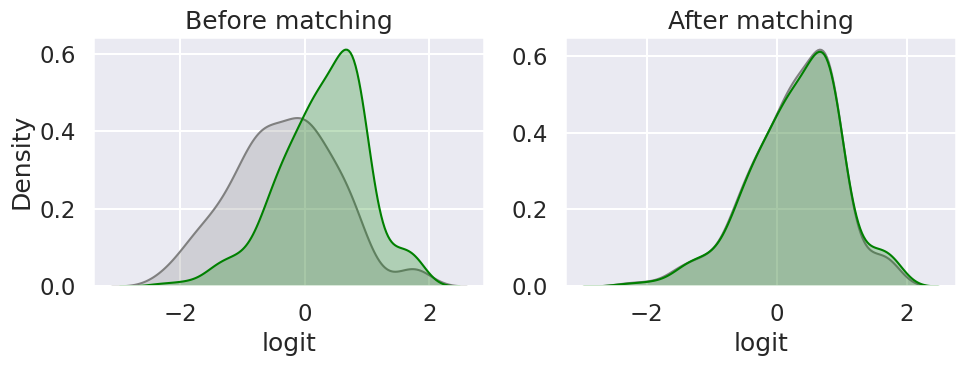

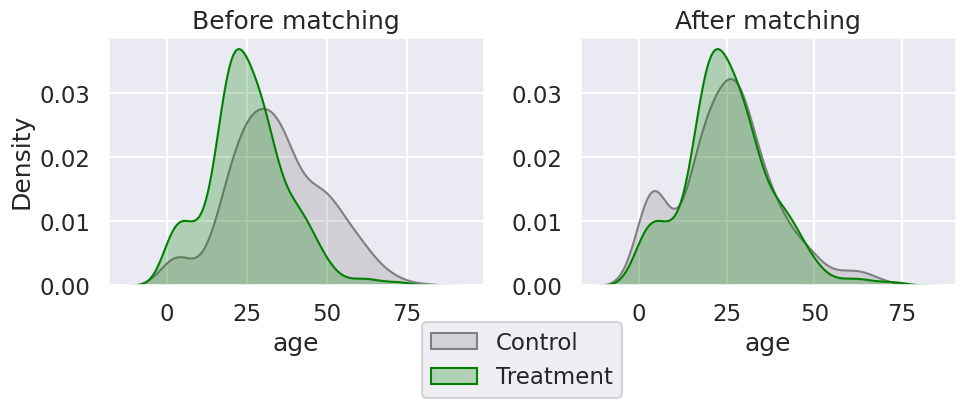

In [ ]:
for var in ['logit', 'age']:
    fig, ax = plt.subplots(1,2,figsize=(10,4))
    # Visualise original distribution
    sns.kdeplot(data=df[~df[TREATMENT]], x=var, fill=True,
                color=C_COLOUR, label=C_LABEL, ax=ax[0])
    sns.kdeplot(data=df[df[TREATMENT]], x=var, fill=True,
                color=T_COLOUR, label=T_LABEL, ax=ax[0])
    ax[0].set_title('Before matching')

    # Visualise new distribution
    sns.kdeplot(data=matched_df[~matched_df[TREATMENT]], x=var,
                fill=True, color=C_COLOUR, label=C_LABEL, ax=ax[1])
    sns.kdeplot(data=matched_df[matched_df[TREATMENT]], x=var,
                fill=True, color=T_COLOUR, label=T_LABEL, ax=ax[1])
    ax[1].set_title('After matching')
    ax[1].set_ylabel("")
    plt.tight_layout()
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3));

Кажется что теперь намного лучше

In [ ]:
print(f"{'is_female'} | Before matching")
display(pd.crosstab(df[TREATMENT], df['is_female'],
                    normalize='index'))
print(f"{'is_female'} | After matching")
display(pd.crosstab(matched_df[TREATMENT], matched_df['is_female'],
            normalize='index'))

is_female | Before matching


is_female,False,True
is_pclass3,,
False,0.56,0.44
True,0.71,0.29


is_female | After matching


is_female,False,True
is_pclass3,,
False,0.68,0.32
True,0.71,0.29


По распределению полов также

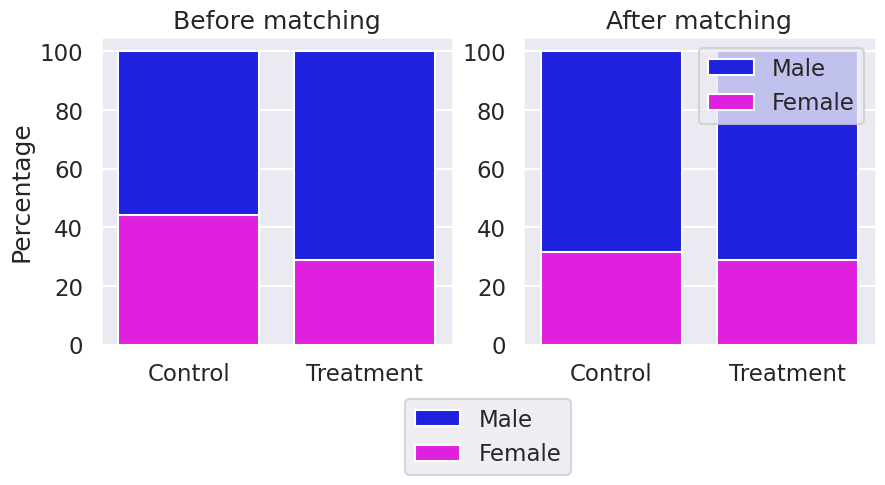

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
# Visualise original distribution
sns.barplot(data=gender, x=gender.index.astype(str), y="All",
            color=M_COLOUR, label=M_LABEL, ax=ax[0])
sns.barplot(data=gender, x=gender.index.astype(str), y='Female',
            color=F_COLOUR, label=F_LABEL, ax=ax[0])
ax[0].legend(loc='center', bbox_to_anchor=(1.1, -0.3))
ax[0].set_xlabel('')
ax[0].set_ylabel('Percentage')
ax[0].set_title('Before matching')
# Visualise new distribution
gender_after = 100 * pd.crosstab(
    matched_df[TREATMENT].replace({True: T_LABEL, False: C_LABEL}),
    matched_df['is_female'].replace({True: 'Female', False: 'Male'}),
    normalize='index'
)
gender_after['All'] = 100
sns.barplot(data=gender_after, x=gender_after.index.astype(str),
            y="All", color=M_COLOUR, label=M_LABEL, ax=ax[1])
sns.barplot(data=gender_after, x=gender_after.index.astype(str),
            y='Female', color=F_COLOUR, label=F_LABEL, ax=ax[1])
ax[1].set_xlabel('')
ax[1].set_title('After matching')
ax[1].set_ylabel('');

Похоже, что соотношение полов стало более выровненным между двумя группами после сопоставления.

Если нас не устраивает результат сопоставления, мы можем вернуться к предыдущим шагам и перенастроить сопоставление до тех пор, пока не получим что-то более качественное. Как только нас устроит сопоставление и мы будем уверены, что смешивающие факторы сбалансированы между группами, можно переходить к следующему этапу — анализу причинного влияния.

# Шаг 5: Оценка влияния эффекта

Вспомним основные понятия:

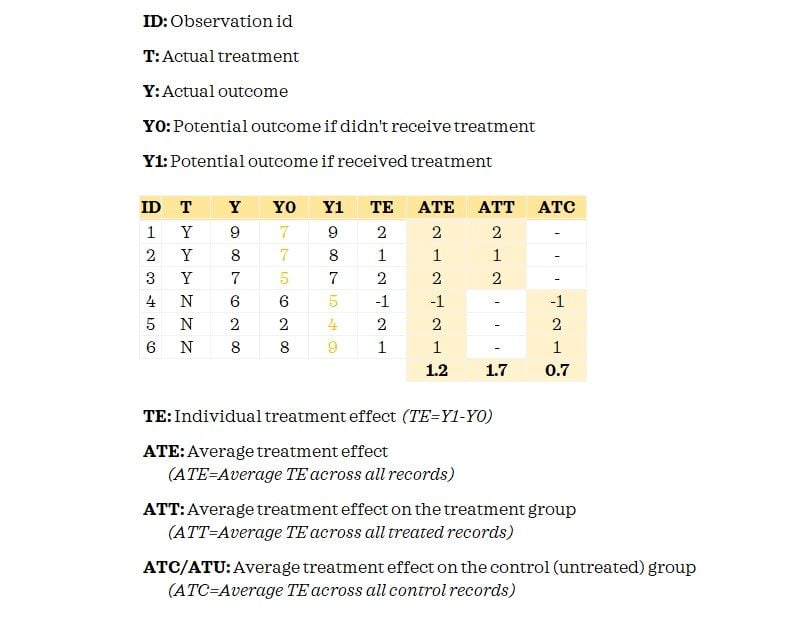

Основная проблема причинно-следственного анализа заключается в том, что мы не наблюдаем оба значения целевых переменных. Мы знаем значение Y0 для контрольной группы и Y1 для тестовой. При сопоставлении записей мы пытались найти приближённое значение Y0 для тестовых пассажиров, чтобы оценить эффект воздействия.

Теперь, разобравшись с этими ключевыми терминами, попробуем оценить ATT (Average Treatment Effect on the Treated — средний эффект воздействия на тех, кто подвергся воздействию). Это связано с тем, что сопоставление было выполнено только для записей, которые получили воздействие. Если бы мы провели полное сопоставление, то могли бы оценить ATE (Average Treatment Effect — средний эффект воздействия на всю выборку).

Вот описательная статистика по исходам между тестовой и новой контрольной группами:

In [ ]:
summary = matched_df.groupby(TREATMENT)[OUTCOME]\
                    .aggregate(['mean', 'std', 'count'])
summary

,mean,std,count
is_pclass3,,,
False,0.46,0.50,355
True,0.24,0.43,355


In [ ]:
c_outcome = summary.loc[False, 'mean']
t_outcome =  summary.loc[True, 'mean']
att = t_outcome - c_outcome
print('The Average Treatment Effect on Treated (ATT): {:.4f}'\
      .format(att))

The Average Treatment Effect on Treated (ATT): -0.2169


Предполагая, что в нашем анализе учтены все смешивающие факторы, мы можем сделать вывод, что получение каюты третьего класса снижает вероятность выживания примерно на 22% среди тех, кто получил такую каюту.

Мы рассмотрели простой пример, чтобы понять интуицию, стоящую за методом сопоставления по склонности. На практике чаще всего более удобно использовать специализированные библиотеки, такие как causalinference, DoWhy или MatchIt в R. Например, с помощью библиотеки causalinference мы можем оценить эффект воздействия следующим образом:

In [ ]:
y = df[OUTCOME].values
t = df[TREATMENT].values
X = df[['is_female', 'age']]
X = pd.DataFrame(StandardScaler().fit_transform(X),
                 columns=X.columns).values
model = CausalModel(y, t, X)
model.est_via_matching()
print(model.estimates)


Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.259      0.046     -5.623      0.000     -0.350     -0.169
           ATC     -0.292      0.056     -5.240      0.000     -0.401     -0.183
           ATT     -0.227      0.052     -4.400      0.000     -0.328     -0.126

